**This notebook analyzes tweets about electronic cigars.


**Opening file with training tweets**

In [3]:
#seach for organic tweets and save them in one list
from collections import Counter
import csv
tweets=[]
positive_tweets = 0
negative_tweets = 0
other_tweets = 0

DATA = 'D:/Research/'

with open( DATA+'2000_Sample_3classes.csv', "rb") as theFile:
    reader = csv.DictReader( theFile )
    for row in reader:
        if row['sent']== '1':
            positive_tweets += 1
        elif row['sent']== '-1':
            negative_tweets += 1
        else:
            other_tweets += 1
            
        tweets.append(row)
        
print 'We have', len(tweets), 'sampled tweets'
print positive_tweets, 'are positive'
print negative_tweets, 'are negative'
print other_tweets, 'are nothing'

We have 2000 sampled tweets
676 are positive
275 are negative
1049 are nothing


Populating the interactive namespace from numpy and matplotlib
label counts= Counter({0: 1049, 1: 676, -1: 275})


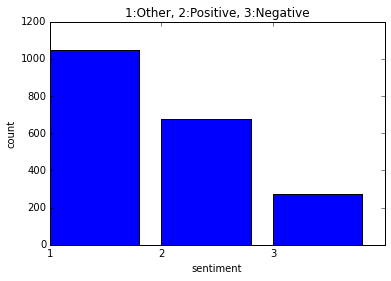

In [15]:
from collections import Counter
import numpy as np
%pylab inline

#Getting true labels from tweets
y = np.array([int(t['sent']) for t in tweets])#savind labels of the class in y
print 'label counts=', Counter(y)


# What is the distribution of scores?
from collections import Counter
import matplotlib.pyplot as plt

counts = Counter(y).values()
vals = [1,2,3]

plt.bar(vals, counts)
plt.xticks(vals)
plt.xlabel('sentiment')
plt.ylabel('count')
plt.title('1:Other, 2:Positive, 3:Negative')
plt.show()

In [7]:
#########################
####Tokenizing method####
#########################

def tokenize1(string, lowercase=True, keep_punctuation=False,collapse_urls=True, collapse_mentions=True):
    if not string:
        return []
    if lowercase:
        string = string.lower()
    tokens = []
    if collapse_urls:
        string = re.sub('http\S+', 'THIS_IS_A_URL', string)
    if collapse_mentions:
        string = re.sub('@\S+', 'THIS_IS_A_MENTION', string)
    if keep_punctuation:
        tokens = string.split()
    else:
        tokens = re.sub('\W+', ' ', string).split()
    return tokens

In [8]:
####################
###Feature vector###
####################
import re 

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(decode_error='ignore', ngram_range=(1, 1), max_df=1.0, min_df=2, tokenizer=tokenize1,binary=False)#lowercase, url's, mentions
X = vectorizer.fit_transform(t['text'] for t in tweets)
print 'Vectorized %d tweets. Found %d terms.' % (X.shape[0], X.shape[1])

Vectorized 2000 tweets. Found 1996 terms.


** Fitting LG model - default parameters**

In [9]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression

def do_cv(X, y, nfolds=10):
    cv = KFold(len(y), nfolds)
    return np.mean(cross_val_score(LogisticRegression(), X, y, cv=cv))
  
print "Accuracy of %.2f" % (do_cv(X, y)*100)

Accuracy of 73.20


In [16]:
# Fit a LogisticRegression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X, y)

# Compute accuracy
def accuracy(truth, predicted):
    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))

predicted = model.predict(X)
print 'Accuracy on training data = %.2f' % (accuracy(y, predicted)*100)


#Cross-validation accuracy
from sklearn.cross_validation import KFold

cv = KFold(len(y), 10)
accuracies = []
for train_ind, test_ind in cv:
    model.fit(X[train_ind], y[train_ind])
    
    predictions = model.predict(X[test_ind])
    accuracies.append(accuracy(y[test_ind], predictions))
    
print 'Average 5-fold cross validation accuracy = %.2f (std = %.2f)' % ((np.mean(accuracies)*100), np.std(accuracies))

Accuracy on training data = 81.90
Average 5-fold cross validation accuracy = 73.20 (std = 0.03)


In [11]:
#confusion matrix for model
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import pandas as pd


y_pred = model.predict(X)

def confusion_matrix(y_test, y_pred):
    cm = sk_confusion_matrix(y, y_pred)
    cm = pd.DataFrame(data=cm, columns=[-1,0,1], index=[-1,0,1])
    cm.columns.name = 'Predicted'
    cm.index.name = 'Expected'
    error_rate = (y_pred != y).mean()
    print('error rate: %.2f' % error_rate)
    return cm
    
confusion_matrix(y, y_pred)

error rate: 0.18


Predicted,-1,0,1
Expected,,,
-1,116,95,64
0,9,989,51
1,5,145,526


In [12]:
#precision, recall and F1 measures for both classes
from sklearn.metrics import precision_recall_fscore_support
y_true = y
y_pred = model.predict(X)
print '1',precision_recall_fscore_support(y_true, y_pred)

1 (array([ 0.89230769,  0.80471928,  0.82059282]), array([ 0.42181818,  0.94280267,  0.77810651]), array([ 0.57283951,  0.86830553,  0.79878512]), array([ 275, 1049,  676], dtype=int64))


**Changing parameters of LG classifier **

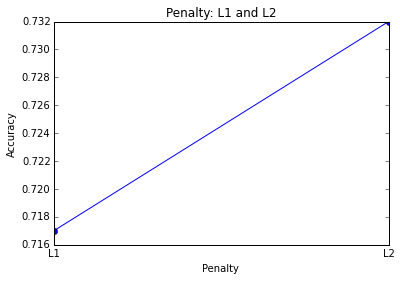

In [13]:
#penalty=l1 and l2
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

def do_cv_penalty(X, y, penalty, nfolds=10):
    cv = KFold(len(y), nfolds)
    return np.mean(cross_val_score(LogisticRegression(penalty=penalty), X, y, cv=cv))
  
def compare_penalty(tweets, y):
    accuracies = []
    clf_param = ['l1','l2']
    i=0
    for pr in clf_param:
        accuracies.append(do_cv_penalty(X,y,penalty=pr))
        #print 'Parameter:', pr, 'Accuracy:', accuracies[i]
        i+=1
    plt.figure()
    plt.plot(accuracies, 'bo-')
    plt.xticks(range(2), ['L1','L2'] )
    plt.title('Penalty: L1 and L2')
               
    plt.xlabel('Penalty')
    plt.ylabel('Accuracy')
    plt.show()
        
compare_penalty(tweets, y)

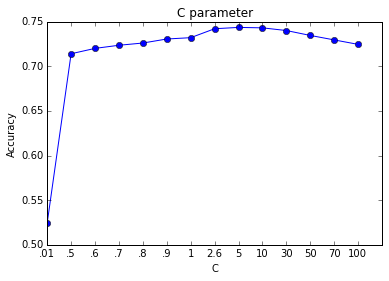

In [14]:
#C
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

def do_cv_C(X, y, c, nfolds=10):
    cv = KFold(len(y), nfolds)
    return np.mean(cross_val_score(LogisticRegression(C=c), X, y, cv=cv))
  
def compare_c(tweets, y):
    accuracies = []
    c_param = [.01, .5,.6,.7,.8,.9,1,2.6, 5, 10, 30,50,70,100]
    i=0
    for c in c_param:
        accuracies.append(do_cv_C(X,y,c))
        #print 'C parameter:',c,'Accuracy:',accuracies[i]
        i+=1
    plt.figure()
    plt.plot(accuracies, 'bo-')
    #plt.xticks(range(len(c)), c)
    #plt.xticks(c_param)
    plt.xticks(range(14), ['.01', '.5','.6','.7','.8','.9','1','2.6' ,'5', '10', '30','50','70','100'])
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.title('C parameter')
    plt.show()   
    
compare_c(tweets, y)

In [23]:
# Do GridSearch on all parameters.
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint

pipeline = Pipeline([
    ('vect', TfidfVectorizer(decode_error='ignore', ngram_range=(1, 1), max_df=1.0, min_df=2, tokenizer=tokenize1,binary=False)),
    ('clf', LogisticRegression()),
])

parameters = {
    'clf__penalty': ('l1','l2'),
    'clf__C': (.01, .5,.6,.7,.8,.9,1,1.5,2,2.5,2.6,3, 5, 10, 30,50,70, 100),  
}

data = [t['text'] for t in tweets]
grid_search = GridSearchCV(pipeline, parameters, verbose=1, cv=KFold(len(y), 10))

print "Performing grid search..."
print "pipeline:", [name for name, _ in pipeline.steps]
print "parameters:"
pprint(parameters)
grid_search.fit(data, y)
print "done."

print("Best score: %0.4f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:   17.0s
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   39.7s finished


Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__C': (0.01,
            0.5,
            0.6,
            0.7,
            0.8,
            0.9,
            1,
            1.5,
            2,
            2.5,
            2.6,
            3,
            5,
            10,
            30,
            50,
            70,
            100),
 'clf__penalty': ('l1', 'l2')}
Fitting 10 folds for each of 36 candidates, totalling 360 fits
done.
Best score: 0.7435
Best parameters set:
	clf__C: 2.5
	clf__penalty: 'l2'


In [17]:
# Fit a LogisticRegression model modified parameters 
from sklearn.linear_model import LogisticRegression
model_mod = LogisticRegression(penalty='l2', C=5)
model_mod.fit(X, y)

# Compute accuracy
def accuracy(truth, predicted):
    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))

predicted = model_mod.predict(X)
print 'accuracy on training data = %.2f' % (accuracy(y, predicted)*100)

#Cross-validation accuracy
from sklearn.cross_validation import KFold

cv = KFold(len(y), 10)
accuracies = []
for train_ind, test_ind in cv:
    model_mod.fit(X[train_ind], y[train_ind])
    
    predictions = model_mod.predict(X[test_ind])
    accuracies.append(accuracy(y[test_ind], predictions))
    
print 'Average 5-fold cross validation accuracy = %.2f (std = %.2f)' % ((np.mean(accuracies)*100), np.std(accuracies))

accuracy on training data = 92.70
Average 5-fold cross validation accuracy = 74.35 (std = 0.03)


In [16]:
#confusion matrix for model_mod (best parameters - actually same default)
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import pandas as pd

y_pred = model_mod.predict(X)

def confusion_matrix(y_test, y_pred):
    cm = sk_confusion_matrix(y, y_pred)
    cm = pd.DataFrame(data=cm, columns=[-1,0,1], index=[-1,0,1])
    cm.columns.name = 'Predicted'
    cm.index.name = 'Expected'
    error_rate = (y_pred != y).mean()
    print('error rate: %.2f' % error_rate)
    return cm
    
confusion_matrix(y, y_pred)

error rate: 0.08


Predicted,-1,0,1
Expected,,,
-1,213,32,30
0,10,1004,35
1,7,51,618


In [17]:
#precision, recall and F1 measures for both classes
from sklearn.metrics import precision_recall_fscore_support
y_true = y
y_pred = model_mod.predict(X)
print precision_recall_fscore_support(y_true, y_pred)

(array([ 0.92608696,  0.92364305,  0.90483163]), array([ 0.77454545,  0.957102  ,  0.91420118]), array([ 0.84356436,  0.94007491,  0.90949227]), array([ 275, 1049,  676], dtype=int64))


# SGD Classifier

In [29]:
# Do GridSearch on all parameters for SGD classifier
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint
from sklearn.linear_model import SGDClassifier

pipeline = Pipeline([
    ('vect', TfidfVectorizer(decode_error='ignore', ngram_range=(1, 1), max_df=1.0, min_df=2, tokenizer=tokenize1,binary=False)),
    ('clf', SGDClassifier()),
])

parameters = {
    'clf__penalty': ('none', 'l2', 'l1', 'elasticnet'),
    'clf__alpha': (.0001, .0005,.0006,.0007,.0008,.0009,.001, 5, 10, 100),  
}

data = [t['text'] for t in tweets]
grid_search = GridSearchCV(pipeline, parameters, verbose=1, cv=KFold(len(y), 10))

print "Performing grid search..."
print "pipeline:", [name for name, _ in pipeline.steps]
print "parameters:"
pprint(parameters)
grid_search.fit(data, y)
print "done."

print("Best score: %0.4f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:   14.1s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   28.4s finished


Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__alpha': (0.0001,
                0.0005,
                0.0006,
                0.0007,
                0.0008,
                0.0009,
                0.001,
                5,
                10,
                100),
 'clf__penalty': ('none', 'l2', 'l1', 'elasticnet')}
Fitting 10 folds for each of 40 candidates, totalling 400 fits
done.
Best score: 0.7450
Best parameters set:
	clf__alpha: 0.001
	clf__penalty: 'none'


**SGD model**

In [18]:
# Fit a SGD model
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(penalty='none', alpha=0.0001)
clf.fit(X, y)

# Compute accuracy
def accuracy(truth, predicted):
    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))

predicted = clf.predict(X)
print 'accuracy on training data=%.2f' % (accuracy(y, predicted)*100)

#Cross-validation accuracy
from sklearn.cross_validation import KFold

cv = KFold(len(y), 10)
accuracies = []

for train_ind, test_ind in cv:
    clf.fit(X[train_ind], y[train_ind])
    
    predictions = clf.predict(X[test_ind])
    accuracies.append(accuracy(y[test_ind], predictions))
    
print 'Average 5-fold cross validation accuracy = %.2f (std=%.2f)' % ((np.mean(accuracies)*100), np.std(accuracies))

accuracy on training data=96.75
Average 5-fold cross validation accuracy = 71.15 (std=0.03)


In [19]:
#Confusion matrix for SGD model
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import pandas as pd

y_pred = clf.predict(X)

def confusion_matrix(y_test, y_pred):
    cm = sk_confusion_matrix(y, y_pred)
    cm = pd.DataFrame(data=cm, columns=[-1,0,1], index=[-1,0,1])
    cm.columns.name = 'Predicted'
    cm.index.name = 'Expected'
    error_rate = (y_pred != y).mean()
    print('error rate: %.2f' % error_rate)
    return cm
    
confusion_matrix(y, y_pred)

error rate: 0.05


Predicted,-1,0,1
Expected,,,
-1,252,13,10
0,12,1010,27
1,8,23,645


In [20]:
#precision, recall and F1 measures for classes from SGD classifier
from sklearn.metrics import precision_recall_fscore_support
y_true = y
y_pred = clf.predict(X)
print '1',precision_recall_fscore_support(y_true, y_pred)

1 (array([ 0.92647059,  0.96558317,  0.9457478 ]), array([ 0.91636364,  0.96282173,  0.95414201]), array([ 0.9213894 ,  0.96420048,  0.94992636]), array([ 275, 1049,  676], dtype=int64))


# Testing not labeled tweets

In [10]:
import gzip

In [11]:
#opening testing tweets
from collections import Counter
import csv
test_tweets=[]
i=1

with open( DATA + 'organicDef.csv', "rb" ) as theFile:
    reader = csv.DictReader( theFile )
    for row in reader:
        test_tweets.append(row) 
        i+=1
        
print 'We have', len(test_tweets), ' tweets'

We have 992633  tweets


In [12]:
# Feature vector for testing tweets 
from sklearn.feature_extraction.text import TfidfVectorizer
XX = vectorizer.transform(t['text'] for t in test_tweets)

**Predicting classes**

In [18]:
prediction = model_mod.predict(XX)

In [40]:
#Printint out some tweets and their classes
i=0
for doc, classe in zip(test_tweets, prediction):
    print('%r => %s' % (doc['text'], classe))
    if i==100:
        break
    i+=1

'Getting an e cig tomorrow :)' => 1
'nickdrake: C3P0 Enjoys a cigarette break during filming. http://t.co/AVCtEml4' => 0
'Really \xe3?? nice!: USB Rechargeable Electronic Cigarette Lighter - Green http://t.co/JS65DjB3' => 0
'Smoking an e-cig is the equivalent to smoking smarties. You look like a faggot' => -1
'Advertise Ecigs HQ on Social Media Sites http://t.co/KmE6lHcq' => 0
'Photo: pizzzatime: nickdrake:\xc2\xa0C3P0 Enjoys a cigarette break during filming. http://t.co/neyow8Go' => 0
"RT @VapeLink: Tomorrow on Vapelink 9:30 EST: Mr. Ecig from Nu-vapor Forum! We'll also talk hardware.news.... and the usual banter!! http ..." => 0
'#starwars RT @pizzzatimes nickdrake: C3P0 Enjoys a cigarette break during filming. http://t.co/NcAlTYRA' => 0
'Ecig finally died #rip' => 1
"I'm defo buying an E-Cig tomorrow!" => 1
'pizzzatime: nickdrake: C3P0 Enjoys a cigarette break during filming.  C3P0 I AM EXTREMELY DISAPPOINTED IN YOU. http://t.co/N3psXH9o' => 0
'lol at the random kid who asked me for

In [146]:
#percentage of positives and negatives tweets from the test set
aaa= list(prediction)
print aaa.count(1)/float(992633) * 100, '% tweets are positive'
print aaa.count(0)/float(992633) *100, '% tweets are neutral'
print aaa.count(-1)/float(992633) *100,'% tweets are negative'


33.4334038864 % tweets are positive
58.6067559712 % tweets are neutral
7.95984014233 % tweets are negative


In [147]:
#top and bottom coeficients for LG model
coefs = sorted(zip(vectorizer.get_feature_names(),model_mod.coef_[0]),key=lambda x:x[1])
print coefs[0:30], '\n'
print coefs[-30:]

[(u'THIS_IS_A_URL', -6.300246471502585), (u'my', -2.7179297342491973), (u'to', -2.6292238206534848), (u'we', -2.3507151722860171), (u'and', -2.2096662817982629), (u'euecigban', -2.0783069669944894), (u'for', -2.057789129975943), (u'good', -2.0018194081505643), (u'ban', -1.9206002638740962), (u'how', -1.8133014840502042), (u'gonna', -1.7869014941702765), (u'need', -1.7453089430811211), (u'vape', -1.7365005912447167), (u'will', -1.6574433050044919), (u'actually', -1.6565447569739722), (u'quit', -1.6269563966154141), (u'over', -1.6055809689989204), (u'last', -1.5784710370104145), (u'i', -1.5643761135225844), (u'of', -1.5542450846913185), (u'or', -1.5508031568258847), (u'ecig', -1.5260301663142515), (u'suck', -1.5138694102816783), (u'retail', -1.4626592080690191), (u'walking', -1.4581975285067015), (u'1', -1.45260468583882), (u'see', -1.4488270084947603), (u'new', -1.4467383521180655), (u'love', -1.4454123545186948), (u'best', -1.4445006346056499)] 

[(u'caught', 2.3105739799491909), (u'fu

In [51]:
#saving the labels in one file
numpy.savetxt(DATA+"probs_3Classes.txt", prediction, delimiter=",")

**Merging files with labels and tweets**

In [19]:
import csv
all1 = []
i=-1

with open(DATA+'Book1.csv','rb') as csvinput:#Book1.csv is the file probsDef, but formated into 1's and 0's
    with open(DATA+'output21.csv', 'wb') as csvoutput:
        with open(DATA+'organicDef.csv') as file1:
            writer = csv.writer(csvoutput, lineterminator='\n')
            reader = csv.reader(csvinput)
            reader1 = csv.reader(file1)

            for row in reader1:
                if i==-1:
                    row[38] = 'class'
                elif i >= 0:
                    row[38]=prediction[i]     
                writer.writerow(row) 
                i+=1
                if i > 992632:
                    break

**Reading file with all testing tweets+classes**

In [21]:
from collections import Counter
import csv
labeled_tweets=[]
pos = 0
neg = 0
neu = 0

with open( DATA+'3classes_classifiedTweets.csv', "rb" ) as theFile:
    reader = csv.DictReader( theFile )
    for row in reader:
        labeled_tweets.append(row)
        if row['class'] == '1':
            pos+=1
        elif row['class'] == '-1':
            neg+=1
        else:
            neu+=1
print pos, ' tweets are positive', neg, 'are negative', 'and', neu, 'are neutral'

331871  tweets are positive 79012 are negative and 581750 are neutral


In [22]:
print labeled_tweets[1]['posted_time'],labeled_tweets[1]['text'],labeled_tweets[1]['class']

10/1/2012 00:01:19 nickdrake: C3P0 Enjoys a cigarette break during filming. http://t.co/AVCtEml4 0


#Parse posted time (date), generate graphs by month

In [3]:
# Tweets by month.
import matplotlib.pyplot as plt
import datetime
%pylab inline
def parse_date(datestring):
    """ Input, e.g., 10/1/2012
    Output, e.g., 2012-10"""
    parts = datestring.split()
    if len(parts) > 1:
        datestring = parts[0]
        parts = datestring.split('/')
        if len(parts) == 3:
            s = (parts[2] if len(parts[2]) == 4 else '20' + parts[2]) + \
            '-' + (parts[0] if len(parts[0]) == 2 else '0'+parts[0])
            return datetime.datetime.strptime(s, "%Y-%m").date()
    return None

Populating the interactive namespace from numpy and matplotlib


All tweets [30026, 36995, 46271, 62883, 65971, 90870, 110735, 84692, 96447, 94180, 114894, 158669] .Total:  992633
Positive tweets [11917, 12662, 15785, 21344, 22633, 27856, 35192, 30464, 29337, 33202, 39877, 51602] .Total:  331871
Negative tweets [2231, 2806, 4914, 4883, 5083, 7071, 6946, 6945, 7332, 6662, 10223, 13916] .Total:  79012


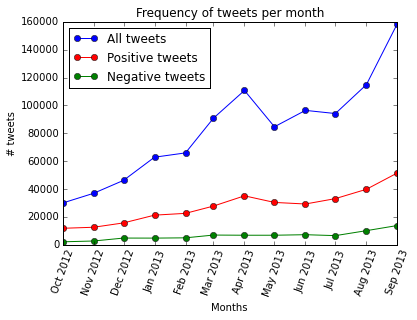

In [4]:
def tweets_by_month(tweets):
    #parsing date for all_tweets, positive and negative
    
    months = Counter(parse_date(x['posted_time']) for x in tweets)#all
    months1 = Counter(parse_date(x1['posted_time']) for x1 in tweets if x1['class']=='1')#positive
    months11 = Counter(parse_date(x0['posted_time']) for x0 in tweets if x0['class']=='-1')#negative
    #months0 = Counter(parse_date(x0['posted_time']) for x0 in tweets if x0['class']=='0')#neutral
    
    result = Counter((k, v) for k, v in months.iteritems() if k is not None)#all
    result1 = Counter((k, v) for k, v in months1.iteritems() if k is not None)#positive
    result11 = Counter((k, v) for k, v in months11.iteritems() if k is not None)#negative
    #result0 = Counter((k, v) for k, v in months0.iteritems() if k is not None)#neutral
    
    keys = [f for f in sorted(result.keys())if f is not None]#all
    keys1 = [d for d in sorted(result1.keys())if d is not None]#positive
    keys11 = [e for e in sorted(result11.keys())if e is not None]#negative
    #keys0 = [e for e in sorted(result0.keys())if e is not None]#neutral
    
    values = [r[1] for r in keys]
    keys = [r[0] for r in keys]
    print 'All tweets', values, '.Total: ',sum(values)

    values1 = [r[1] for r in keys1]
    keys1 = [r[0] for r in keys1]
    print 'Positive tweets', values1, '.Total: ',sum(values1)

    values11 = [r[1] for r in keys11]
    keys11 = [r[0] for r in keys11]
    print 'Negative tweets', values11, '.Total: ',sum(values11)
    
    #values0 = [r[1] for r in keys0]
    #keys0 = [r[0] for r in keys0]
    #print 'Neutral tweets', values11, '.Total: ',sum(values11)


    plt.figure()
    ax = plt.subplot(111)
    plt.xticks(rotation=70) 
    ax.xaxis_date()
    #plt.plot(keys, values, keys1, values1, keys0, values0)
    line, = plt.plot(keys, values,'bo-', label="Line ")#all
    line1, = plt.plot(keys1, values1, 'ro-',label="Line 1")#positive
    line11, = plt.plot(keys11, values11, 'go-',label="Line 11")#negative
    #line0, = plt.plot(keys0, values0, 'ko-',label="Line 0")#neutral
    plt.xlabel('Months')
    plt.ylabel('# tweets')
    plt.title('Frequency of tweets per month')
    plt.legend([line, line1,line11], ["All tweets", "Positive tweets", "Negative tweets"], loc=0)

    
tweets_by_month(labeled_tweets)

** Considering just users who posted once**

In [5]:
# Retain tweets from users who have tweeted once.
user_counts = Counter(t['username'] for t in labeled_tweets)
tweets = [t for t in labeled_tweets if user_counts[t['username']] == 1]
print '%d tweets from users who tweeted once' % len(tweets)

418315 tweets from users who tweeted once


All tweets [14965, 15881, 20845, 27189, 27868, 41220, 33154, 33932, 42590, 39556, 51389, 69726] .Total:  418315
Positive tweets [6621, 6534, 8258, 10414, 10979, 13275, 12574, 12731, 11950, 14035, 17444, 22060] .Total:  146875
Negative tweets [1584, 1831, 3863, 3274, 3411, 4827, 4326, 4340, 4964, 4233, 6874, 9576] .Total:  53103


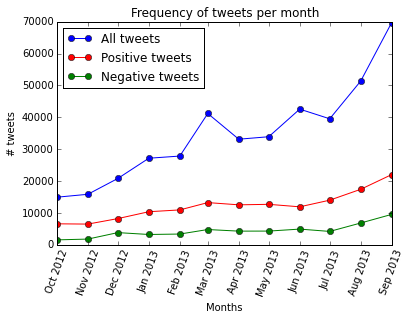

In [6]:
tweets_by_month(tweets)

** Eliminating retweets**

In [7]:
# Remove retweets
tweets_ = [t for t in tweets if t['text'][:2] != 'RT']
print '%d no RT tweets from users who tweeted once' % len(tweets)

418315 no RT tweets from users who tweeted once


All tweets [10975, 12322, 14327, 20676, 21276, 28038, 23588, 24236, 29049, 27650, 34975, 46371] .Total:  293483
Positive tweets [4574, 5386, 6501, 8732, 8720, 11143, 9715, 10195, 9789, 10861, 13071, 15683] .Total:  114370
Negative tweets [1291, 1285, 1405, 2183, 2143, 3046, 2691, 2673, 2561, 2740, 4060, 5712] .Total:  31790


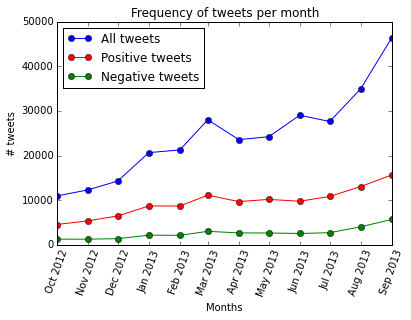

In [8]:
tweets_by_month(tweets_)

In [9]:
countss = Counter(str(v['text']).lower() for v in tweets)
#print str(tweets)
countss.most_common(10)

[('hi guys hello to all my friends if u are really my loved ones check about electronic cigarettes.its work dear',
  3022),
 ('rt @yaboylilb: *gets in booster seat*  *puts seatbelt on*  *puts in the newest kidzbop cd*  *takes drag of e-cig*  *lowers glasses*  *whisp\xe2?\xa6',
  2061),
 ('blackfriday #blackfriday  is too good for me because i used electronic cigarette which  i missed a lot',
  1784),
 ('rt @marinasdiamonds: electric cigarettes taste like school discos', 1379),
 ('blackfriday blackfriday  is too good for me because i used electronic cigarette which  i missed a lot',
  1225),
 ('rt @queen_uk: right. sorry about this. apparently camilla unplugged facebook to plug in an electric heater/cigarette lighter. awkward.',
  1138),
 ('1.6% original tobacco cartomizers.... office favorite vapes!', 1069),
 ("rt @girlcode: don't smoke cigarettes, smoke poles and by poles i mean penises. #girlcode - @tanishalong",
  1013),
 ('rt @overlymanlymann: electronic cigarettes? you mean pussy 

#**Getting percentage of positive users**

In [10]:
import collections as c
d = c.defaultdict(list)
dd = c.defaultdict(list)
#getting username and the class of his/her tweet
for t in labeled_tweets:
    u = t['username']
    label = int(t['class'])
    date = parse_date(t['posted_time'])
    d[u,label,date] 
    if t['text'][:2] != 'RT': 
        dd[u,label,date]

print len(d), "positive tweets in total"
print len(dd), "not considering rt's"

676701 positive tweets in total
507586 not considering rt's


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


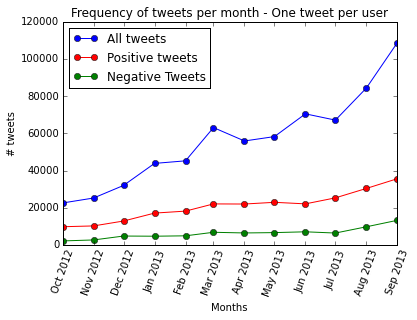

In [11]:
################################
#CONSIDERING ONE TWEET PER USER#
################################

#couting number of tweets by month
all_mon = Counter(x[2] for x in d)
monthpositive = Counter(x[2] for x in d if x[1]==1)
#monthneutral = Counter(x[2] for x in d if x[1]==0)
monthnegative = Counter(x[2] for x in d if x[1]==-1)

#ordering by month
all_key = [f for f in sorted(all_mon.items())if f is not None]
keyspositive = [f for f in sorted(monthpositive.items())if f is not None]
keysnegative = [f for f in sorted(monthnegative.items())if f is not None]
#keysneutral = [f for f in sorted(monthneutral.items())if f is not None]


all_values = [r[1] for r in all_key]
all_keys = [r[0] for r in all_key]

valuespositive = [r[1] for r in keyspositive]
keyspositive1 = [r[0] for r in keyspositive]

valuesposneg = [r[1] for r in keysnegative]
keysposneg = [r[0] for r in keysnegative]

#valuesposneu = [r[1] for r in keysneutral]
#keysposneu = [r[0] for r in keysneutral]

%pylab inline
plt.figure()
ax = plt.subplot(111)
plt.xticks(rotation=70) 
ax.xaxis_date()
linepos, = plt.plot(keyspositive1, valuespositive,'ro-')
lineg, = plt.plot(keysposneg, valuesposneg,'go-')
all_line, = plt.plot(all_keys, all_values,'bo-')
#lineneu, = plt.plot(keysposneu, valuesposneu, 'ko-')
plt.xlabel('Months')
plt.ylabel('# tweets')
plt.title('Frequency of tweets per month - One tweet per user')
plt.legend([all_line,linepos, lineg], ["All tweets","Positive tweets", "Negative Tweets"], loc=0)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


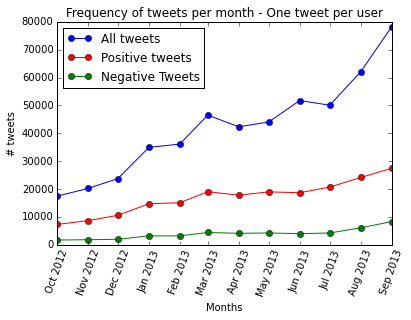

In [12]:
#couting number of tweets by month
all_mon = Counter(x[2] for x in dd)
monthpositive = Counter(x[2] for x in dd if x[1]==1)
#monthneutral = Counter(x[2] for x in dd if x[1]==0)
monthnegative = Counter(x[2] for x in dd if x[1]==-1)

#ordering by month
all_key = [f for f in sorted(all_mon.items())if f is not None]
keyspositive = [f for f in sorted(monthpositive.items())if f is not None]
keysnegative = [f for f in sorted(monthnegative.items())if f is not None]
#keysneutral = [f for f in sorted(monthneutral.items())if f is not None]


all_values = [r[1] for r in all_key]
all_keys = [r[0] for r in all_key]

valuespositive = [r[1] for r in keyspositive]
keyspositive1 = [r[0] for r in keyspositive]

valuesposneg = [r[1] for r in keysnegative]
keysposneg = [r[0] for r in keysnegative]

#valuesposneu = [r[1] for r in keysneutral]
#keysposneu = [r[0] for r in keysneutral]

%pylab inline
plt.figure()
ax = plt.subplot(111)
plt.xticks(rotation=70) 
ax.xaxis_date()
linepos, = plt.plot(keyspositive1, valuespositive,'ro-')
lineg, = plt.plot(keysposneg, valuesposneg,'go-')
all_line, = plt.plot(all_keys, all_values,'bo-')
#lineneu, = plt.plot(keysposneu, valuesposneu, 'ko-')
plt.xlabel('Months')
plt.ylabel('# tweets')
plt.title('Frequency of tweets per month - One tweet per user')
plt.legend([all_line,linepos, lineg], ["All tweets","Positive tweets", "Negative Tweets"], loc=0)

248426
[9779, 10216, 12851, 17107, 18176, 22048, 21986, 22907, 22076, 25304, 30372, 35604]  total 248426 

[(datetime.date(2012, 10, 1), 9779), (datetime.date(2012, 11, 1), 10216), (datetime.date(2012, 12, 1), 12851), (datetime.date(2013, 1, 1), 17107), (datetime.date(2013, 2, 1), 18176), (datetime.date(2013, 3, 1), 22048), (datetime.date(2013, 4, 1), 21986), (datetime.date(2013, 5, 1), 22907), (datetime.date(2013, 6, 1), 22076), (datetime.date(2013, 7, 1), 25304), (datetime.date(2013, 8, 1), 30372), (datetime.date(2013, 9, 1), 35604)]
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


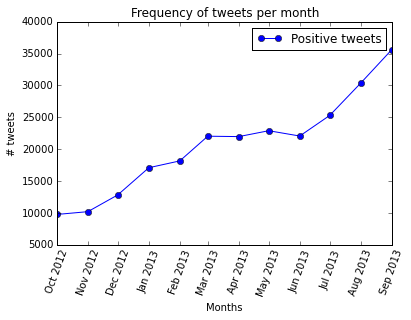

In [13]:
############################
#CONSIDERING JUST POSITIVE##
############################
#deleting keys which have label 0
for k,v in d.items():
    if k[1] != 1:
        del d[k]
print len(d)
#couting number of tweets by month
monthpos = Counter(x[2] for x in d)

#ordering by month
keyspos = [f for f in sorted(monthpos.items())if f is not None]

valuespos = [r[1] for r in keyspos]
keyspos1 = [r[0] for r in keyspos]
print valuespos,' total',  sum(valuespos),'\n'
print sorted(monthpos.items())

#plotting positive tweets by tweets, considering just one positive tweet by user   
%pylab inline
plt.figure()
ax = plt.subplot(111)
plt.xticks(rotation=70) 
ax.xaxis_date()
linepos, = plt.plot(keyspos1, valuespos,'bo-')
plt.xlabel('Months')
plt.ylabel('# tweets')
plt.title('Frequency of tweets per month')
plt.legend([linepos], ["Positive tweets"], loc=0)

In [14]:
#counting tweets per month
all_users = Counter(parse_date(x['posted_time']) for x in labeled_tweets if x['class']!='0')

#ordering by month
keys_all_users = [f for f in sorted(all_users.items())if f is not None]

values_all_users = [r[1] for r in keys_all_users]
keys_all_pos1 = [r[0] for r in keys_all_users]

#print all_users
print "Total tweets by month, excluding neutral: ", values_all_users,'\n'
#print keys_all_pos1


#just positive tweets
positive_users = monthpos

#ordering by month
keys_positive_users = [f for f in sorted(positive_users.items())if f is not None]

values_positive_users = [r[1] for r in keys_positive_users]
keys_pos1 = [r[0] for r in keys_positive_users]

print "Positive tweets by month",values_positive_users,'\n'

Total tweets by month, excluding neutral:  [14148, 15468, 20699, 26227, 27716, 34927, 42138, 37409, 36669, 39864, 50100, 65518] 

Positive tweets by month [9779, 10216, 12851, 17107, 18176, 22048, 21986, 22907, 22076, 25304, 30372, 35604] 



[40.87014669620094, 39.775735866687434, 38.30402384500745, 39.477084967923574, 39.606031552340276, 38.69767441860465, 34.28669452934939, 37.97831421181776, 37.57936845688995, 38.82887306653572, 37.742320310169994, 35.20895551907597]


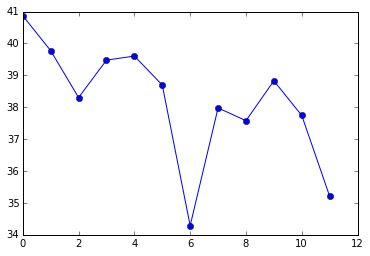

In [16]:
positive_percentil = []
for x, y in zip(values_all_users,values_positive_users):
    positive_percentil.append((y/float(y+x)*100))
print positive_percentil
plot(positive_percentil, 'bo-')

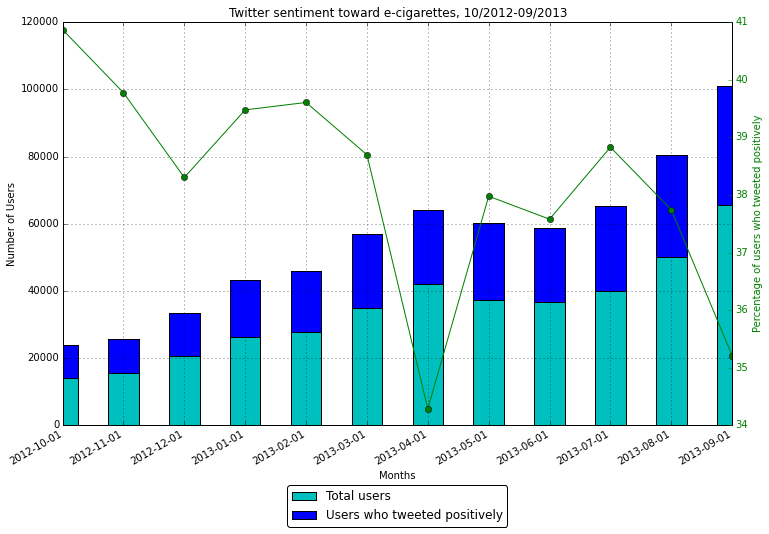

In [17]:
import pandas as pd

data1 = values_all_users
data2 = values_positive_users
B=positive_percentil
df=pd.DataFrame({'Total users':data1, 'Users who tweeted positively':data2})

df.plot(kind='bar', stacked=True,grid = True,figsize=(12,8), color='cb')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],keys_pos1)
plt.xlabel('Months')
plt.legend(loc='center',fontsize = 'large',bbox_to_anchor=(0.5,-0.2),
          ncol=1, fancybox=True)
plt.title('Twitter sentiment toward e-cigarettes, 10/2012-09/2013')

df1=pd.DataFrame({'positive_percentil':positive_percentil})
ax= df1.positive_percentil.plot(kind='line',secondary_y=True, style='go-')
ax.left_ax.set_ylabel('Number of Users')
ax.right_ax.set_ylabel('Percentage of users who tweeted positively', color='green')
ax.xaxis_date()
#plt.legend(('Positive percentile over all all tweets',),bbox_to_anchor=(0.9,-0.16),fancybox=True)
ax.tick_params(axis='y', colors='green')
gcf().autofmt_xdate()


#Create model to check top coefficient words by month

In [167]:
positive_ones = [(t['text'],parse_date(t['posted_time'])) for t in labeled_tweets if t['class']=='1']
positive_ones1 = [(t['text'],parse_date(t['posted_time'])) for t in labeled_tweets]

In [168]:
import re 

Y_pos = [p[1] for p in positive_ones1]

# Create feature vectors (X)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer1 = TfidfVectorizer(decode_error='ignore', ngram_range=(1, 1), max_df=1.0, min_df=10, tokenizer=tokenize1,binary=False)#lowercase, url's, mentions
X_pos = vectorizer1.fit_transform(t[0] for t in positive_ones1)
print 'vectorized %d tweet. found %d terms.' % (X_pos.shape[0], X_pos.shape[1])

vectorized 992633 tweet. found 30236 terms.


In [169]:
# Fit a LogisticRegression model
from sklearn.linear_model import LogisticRegression
model_positive = LogisticRegression()
model_positive.fit(X_pos, Y_pos)

# Compute accuracy
def accuracy(truth, predicted):
    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))

predicted = model_positive.predict(X_pos)
print 'Accuracy on training data = %.3f' % (accuracy(Y_pos, predicted)*100)

from sklearn.cross_validation import KFold
cv = KFold(len(Y_pos), 10)

Accuracy on training data = 42.999


In [170]:
# What are the top weighted features?
vocab = np.array(vectorizer1.get_feature_names())
# Get the learned coefficients for the Positive class.
var=[]
for i in range(0,12):
    coef = model_positive.coef_[i]
    # Sort them in descending order.
    top_coef_ind = np.argsort(coef)[::-1]
    # Get the names of those features.
    top_coef_terms = vocab[top_coef_ind]
    # Get the weights of those features
    top_coef = coef[top_coef_ind]
    # Print the top 10.
    var.append([(term, weight) for term, weight in zip(top_coef_terms, top_coef)[:10]])
    #print '\n', \
    #'\n'.join('%s %.2f' % (term, weight) for term, weight in zip(top_coef_terms, top_coef)[:10])

months_ = ['Oct','Nov','Dec,','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']

for v,m in zip(var,months_):
    print m, '\n', v, '\n'

Oct 
[(u'dragonfly', 16.813914114249894), (u'ltdTHIS_IS_A_URL', 8.7403712029209295), (u'stoptober', 7.8910750808525671), (u'discos', 6.8504299381439715), (u'clik', 6.7058373953299633), (u'mall', 6.5563861364743881), (u'clintandrew', 6.2920185616551443), (u'fuckingsmart', 6.2790935878734562), (u'dispoecig', 6.2483942974499627), (u'ohmyvapor', 6.0619599245067333)] 

Nov 
[(u'election', 10.118699199197648), (u'thanksgiving', 8.6074402611038376), (u'election2012', 8.1729693620581205), (u'sarapmagvape', 7.7053961674996545), (u'sideburn', 6.812930498303909), (u'pattinson', 6.6113933512021408), (u'shishavapes', 5.9613644834052515), (u'nov', 5.639123015450437), (u'emazin', 5.5989815684462378), (u'rob', 5.4683811157215185)] 

Dec, 
[(u'mhealth', 9.2888743831401026), (u'christmas', 8.2638755342716532), (u'youcantbetakenseriouslyif', 7.965140094695478), (u'ganj', 7.7397079042758596), (u'xmas', 7.1064518211112357), (u'dec', 6.9981061938049445), (u'govawards', 6.3264323433067862), (u'itsabaddaywhen